# Figure 10 - Effects of sonophore membrane coverage on neural responses

### Matplotlib parameters

In [11]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'arial'

### Imports

In [12]:
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PySONIC.utils import logger, si_format
from PySONIC.plt import CompTimeSeries
from PySONIC.core import NeuronalBilayerSonophore
from PySONIC.neurons import getPointNeuron
from ExSONIC.core import SonicNode, ExtendedSonicNode
from utils import saveFigsAsPDF, prependTimeSeries

Set high logging level to avoid extra logging

In [13]:
logger.setLevel(logging.ERROR)

### Plot parameters

In [14]:
figindex = 10
fs = 12
tracefig_size = (8, 6)
thrfig_size = (6, 5)
figs = {}

### Simulation parameters

In [15]:
pneuron = getPointNeuron('RS')
a = 32e-9       # m
Fdrive = 500e3  # Hz
PRF = 100.0     # s
DC = 1.0
deff = 100e-9   # m
rs = 1e2        # Ohm.cm

## Panel A: neural responses at 50% coverage

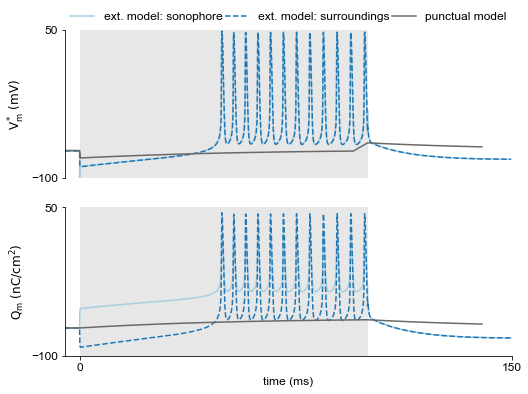

In [16]:
# Stimulation parameters
Adrive = 50e3   # kPa
tstim = 100e-3   # s
toffset = 50e-3  # s
cov = 0.5

# Simulate punctual SONIC model with specific membrane coverage
punctual_model = SonicNode(pneuron, a=a, Fdrive=Fdrive, fs=cov)
punctual_data, _ = punctual_model.simulate(Adrive, tstim, toffset, PRF, DC)

# Simulate extended SONIC model with specific membrane coverage
ext_model = ExtendedSonicNode(
    pneuron, rs, a=a, Fdrive=Fdrive, fs=cov, deff=deff)
ext_data, _ = ext_model.simulate(Adrive, tstim, toffset, PRF, DC)

# Add onset to solutions
tonset = 5e-3
punctual_data = prependTimeSeries(punctual_data, tonset)
for k, df in ext_data.items():
    ext_data[k] = prependTimeSeries(df, tonset)

# Get stimulus patches
t = punctual_data['t'].values  # s
stimon = punctual_data['stimstate']
tpatch_on, tpatch_off = CompTimeSeries.getStimPulses(t, stimon)

# Create figure
fig, axes = plt.subplots(2, 1, figsize=tracefig_size)
for ax in axes:
    for key in ['right', 'top']:
        ax.spines[key].set_visible(False)
    ax.set_xlim(-tonset * 1e3, (tstim + toffset) * 1e3)
    ax.set_ylim(-100, 50)
    ax.set_yticks(ax.get_ylim())
    for i in range(tpatch_on.size):
        ax.axvspan(tpatch_on[i] * 1e3, tpatch_off[i] * 1e3, edgecolor='none',
                   facecolor='#8A8A8A', alpha=0.2)
ax = axes[0]
ax.set_ylabel('$\\rm V_m^*\ (mV)$', fontsize=fs)
ax.set_xticks([])
ax.spines['bottom'].set_visible(False)
ax = axes[1]
ax.set_xlabel('time (ms)', fontsize=fs)
ax.set_ylabel('$\\rm Q_m\ (nC/cm^2)$', fontsize=fs)
ax.set_xticks([0, (tstim + toffset) * 1e3])
ax.set_xticklabels(['{:.0f}'.format(x) for x in ax.get_xticks()])

# Plot membrane potential and charge density profiles
colors = plt.get_cmap('Paired').colors[:2]
linestyles = ['-', '--']
for i, (key, df) in enumerate(ext_data.items()):
    axes[0].plot(df['t'] * 1e3, df['Vm'], linestyles[i], c=colors[i], label=f'ext. model: {key}')
    axes[1].plot(df['t'] * 1e3, df['Qm'] * 1e5, linestyles[i], c=colors[i])
axes[0].plot(t * 1e3, punctual_data['Vm'], c='dimgrey', label='punctual model')
axes[1].plot(t * 1e3, punctual_data['Qm'] * 1e5, c='dimgrey')

# Add legend
axes[0].legend(
    frameon=False, fontsize=fs, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
    ncol=3, mode='expand', borderaxespad=0.)

# Post-process figure
for ax in axes:
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(fs)

figs['a'] = fig

## Panel B: threshold curves

Comparison of excitation threshold amplitudes of the punctual and nanoscale spatially-extended SONIC models for a range of sonophore coverage fractions.**The rendering may take a few seconds...**
 

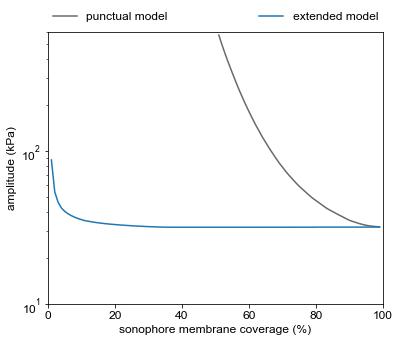

In [17]:
# Stimulation parameters
tstim = 1000e-3  # s
toffset = 0e-3  # s
cov_range = np.linspace(0.01, 0.99, 99)

# Compute threshold amplitudes with point-neuron model
Athr0D = np.empty(cov_range.size)
for i, cov in enumerate(cov_range):
    model = SonicNode(pneuron, a=a, Fdrive=Fdrive, fs=cov)
    Athr0D[i] = model.titrate(tstim, toffset, PRF=PRF, DC=DC)
    model.clear()

# Compute threshold amplitudes with spatially-extended model
Athr1D = np.empty(cov_range.size)
for i, cov in enumerate(cov_range):
    model = ExtendedSonicNode(pneuron, rs, a=a, Fdrive=Fdrive, fs=cov, deff=deff)
    Athr1D[i] = model.titrate(tstim, toffset, PRF=PRF, DC=DC)
    model.clear()

# Plot threshold curves as a function of coverage fraction, for various sub-membrane depths
fig, ax = plt.subplots(figsize=thrfig_size)
ax.set_xlabel('sonophore membrane coverage (%)', fontsize=fs)
ax.set_ylabel('amplitude (kPa)', fontsize=fs)
ax.plot(cov_range * 100, Athr0D * 1e-3, c='dimgrey', label='punctual model')
ax.plot(cov_range * 100, Athr1D * 1e-3, c='C0', label='extended model')
ax.set_yscale('log')
ax.set_xlim(0, 100)
ax.set_ylim(1e1, 6e2)
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(fs)
ax.legend(frameon=False, fontsize=fs, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
          ncol=2, mode='expand', borderaxespad=0.)

figs['b'] = fig

### Save figure panels

Save figure panels as **pdf** in the *figs* sub-folder:

In [18]:
saveFigsAsPDF(figs, figindex)